# RGBD Hand Pose Estimation

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from keras.layers import (
    Add,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    Input,
    MaxPool2D
)
from sklearn.model_selection import train_test_split
from typing import Iterable, List, Tuple

## Data

### Download

In [ ]:
!mkdir model

In [ ]:
%%bash
# Develop

mkdir -p /content/EgoDexter/data/Desk/color
mkdir -p /content/EgoDexter/data/Desk/depth
mv annotation.txt /content/EgoDexter/data/Desk
mv *_color.png /content/EgoDexter/data/Desk/color
mv *_color.png /content/EgoDexter/data/Desk/color
mv *_depth.png /content/EgoDexter/data/Desk/depth

In [ ]:
%%bash
# Train

wget http://handtracker.mpi-inf.mpg.de/data/EgoDexter.zip -P data/
unzip -q -d ./ data/EgoDexter.zip
rm data/EgoDexter.zip

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Constants

In [ ]:
DATA_PATH = "/content/EgoDexter/data/Desk"
IMG_PATH = f"{DATA_PATH}/color"
DEPTH_PATH = f"{DATA_PATH}/depth"
KPS_2D_PATH = f"{DATA_PATH}/annotation.txt"
KPS_3D_PATH = f"{DATA_PATH}/annotation.txt_3D.txt"

DIMS = (480, 640)
BATCH_SIZE = 4
EPOCHS = 20

### Camera matrix, calibration

In [ ]:
K_d = np.array([
  [475.62,  0,      311.125,  0],
  [0,       475.62, 245.965,  0],
  [0,       0,      1,        0]
])

K_d_inv = np.zeros((4, 3))
K_d_inv[:-1, :] = np.linalg.inv(K_d[:, :-1]) * K_d[0, 0]
K_d_inv[-1, :] = [0, 0, 1]

K_c = np.array([
  [617.173, 0,        315.453,  0],
  [0,       617.173,  242.259,  0],
  [0,       0,        1,        0]
])

K_c_inv = np.zeros((4, 3))
K_c_inv[:-1, :] = np.linalg.inv(K_c[:, :-1]) * K_c[0, 0]
K_c_inv[-1, :] = [0, 0, 1]

R_c = np.array([
  [1.0000,      0.00090442, -0.0074,  0],
  [-0.00071933, 0.9997,     0.0248,   0],
  [0.0075,      -0.0248,    0.9997,   0],
  [0,           0,          0,        1]
])

R_c_inv = np.linalg.inv(R_c)

T_c = np.array([
  [1, 0,  0,  20.2365],
  [0, 1,  0,  1.2846],
  [0, 0,  1,  5.7360],
  [0, 0,  0,  1]
])

T_c_inv = np.linalg.inv(T_c)

H_d2c = K_c @ R_c @ T_c @ K_d_inv
H_c2d = K_d @ T_c_inv @ R_c_inv @ K_c_inv


# def camera_transform_kps(pixels: np.ndarray) -> np.ndarray:
#   out = np.zeros(pixels.shape)
#   for i, p in enumerate(pixels):
#     p_h = np.ones(3)
#     p_h[:2] = p
#     out[i, :] = (H_d2c @ p_h)[:-1]
#   return out


def camera_transform_color_to_depth(src: np.ndarray) -> np.ndarray:
  """
  Transforms an image taken from the color camera perspective to
  the depth camera perspective.
  """
  h, w = src.shape[:2]
  dst = np.zeros(src.shape)
  return cv2.warpPerspective(src, H_c2d, (w, h), dst, cv2.INTER_NEAREST, cv2.BORDER_CONSTANT, 0)

### Helper functions

In [ ]:
def batch_gen(batch_size: int, ds_x, ds_y) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
  depth_ds = [p.replace("color", "depth") for p in ds_x]
  n = len(ds_x)

  # for rgb_path, d_path, kps in zip(img_ds, depth_ds, kps_ds):
  while True:
    for i_ in range(0, n//batch_size):
      i = i_ * batch_size
      batch_x = np.zeros((batch_size, *DIMS, 4))
      batch_y = np.zeros((batch_size, *DIMS, 5))
      for j in range(batch_size):
        img = cv2.imread(ds_x[i+j])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = camera_transform_color_to_depth(img)
        depth = cv2.imread(depth_ds[i+j], cv2.IMREAD_GRAYSCALE)
        depth = np.expand_dims(depth, axis=-1)
        batch_x[j] = np.concatenate((img, depth), axis=-1)
        batch_y[j] = kps_to_heatmaps(ds_y[i+j])

      yield batch_x, batch_y


def read_kps() -> np.ndarray:
  with open(KPS_2D_PATH, 'r') as f:
    lines = [l.replace(';', ',').split(", ")[:-1] for l in f.readlines()]

  kps = (-1) * np.ones((len(lines), 10))
  for i, line in enumerate(lines):
    for j, num in enumerate(line):
      kps[i, j] = int(num)

  return kps.reshape((-1, 5, 2))


def kps_to_heatmaps(kps: np.ndarray, sigma: float = 13.) -> np.ndarray:
    n = kps.shape[0]
    h, w = DIMS
    y, x = np.mgrid[0:h, 0:w]
    heatmap = np.zeros((h, w, n))
    for i, kp in enumerate(kps):
      if kp[0] == -1 or kp[1] == -1:
        continue
      a = 1./(2*sigma**2) + 1./(2*sigma**2)
      c = 1./(2*sigma**2) + 1./(2*sigma**2)
      g = np.exp( - (a*((x-kp[0])**2) + c*((y-kp[1])**2)))
      heatmap[..., i] = g.ravel().reshape(DIMS)
    return heatmap


def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap


#Use base cmap to create transparent
mycmap = transparent_cmap(plt.cm.Reds)

### Train, test datasets

In [ ]:
IMG_DS = sorted([os.path.join(r[0], f) for r in os.walk(IMG_PATH) for f in r[2]])
KPS_DS = read_kps()

x_train, x_test, y_train, y_test = train_test_split(IMG_DS, KPS_DS, test_size=0.2)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5)

print(f"Train dataset size: {len(x_train)}")
print(f"Validation dataset size: {len(x_valid)}")
print(f"Test dataset size: {len(x_test)}")

Train dataset size: 440
Validation dataset size: 55
Test dataset size: 56


### Demo

In [ ]:
kps = KPS_DS[0]
img = cv2.imread("/content/EgoDexter/data/Desk/color/image_00000_color.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
depth = cv2.imread("/content/EgoDexter/data/Desk/depth/image_00000_depth.png")

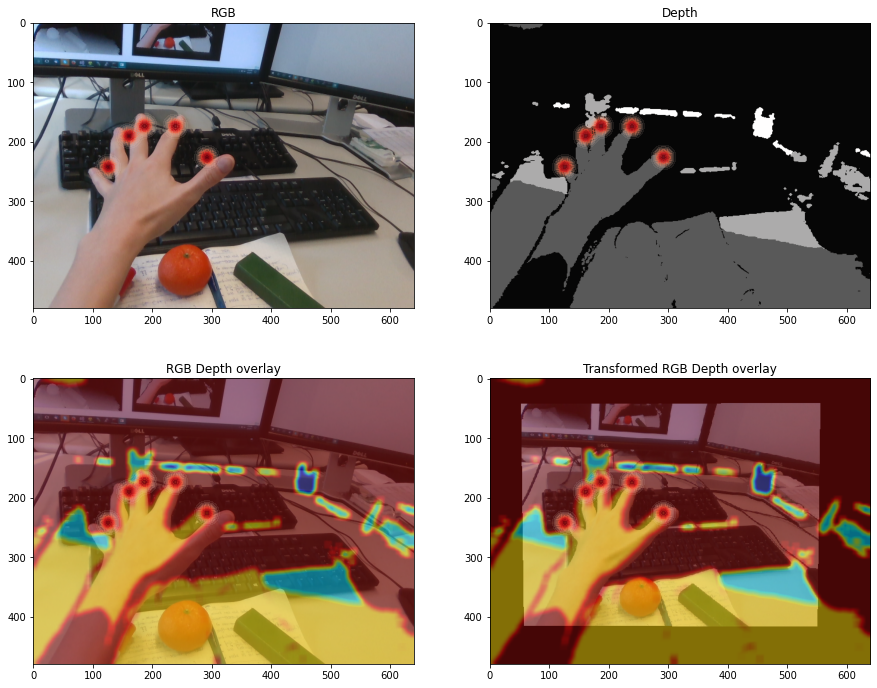

In [ ]:
# Transformed RGB image
img_t = camera_transform_color_to_depth(img)

# Normalized depth image
depth_norm = np.zeros(depth.shape)
depth_norm = cv2.normalize(depth,  depth_norm, 0, 255, cv2.NORM_MINMAX)
depth_blur = cv2.GaussianBlur(depth_norm, (13,13), 11)
depth_map = cv2.applyColorMap(depth_blur, cv2.COLORMAP_JET)

# RGB & depth overly
img_depth = cv2.addWeighted(img, 0.5, depth_map, 0.5, 0)
img_t_depth = cv2.addWeighted(img_t, 0.5, depth_map, 0.5, 0)

# Kepoints heatmaps
hm = kps_to_heatmaps(kps).sum(axis=-1)
y, x = np.mgrid[0:DIMS[0], 0:DIMS[1]]

fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax[0, 0].imshow(img)
ax[0, 0].contourf(x, y, hm, 15, cmap=mycmap)
ax[0, 0].set_title("RGB")
ax[0, 1].imshow(depth_norm)
ax[0, 1].contourf(x, y, hm, 15, cmap=mycmap)
ax[0, 1].set_title("Depth")
ax[1, 0].imshow(img_depth)
ax[1, 0].contourf(x, y, hm, 15, cmap=mycmap)
ax[1, 0].set_title("RGB Depth overlay")
ax[1, 1].imshow(img_t_depth)
ax[1, 1].contourf(x, y, hm, 15, cmap=mycmap)
ax[1, 1].set_title("Transformed RGB Depth overlay")

plt.show()

## Kepoints estimation

### Model

In [ ]:
def get_model() -> tf.keras.models.Model:
  input = Input(shape=(*DIMS, 4))

  x = Conv2D(32, (7, 7), (2, 2), padding="same", activation="relu", data_format="channels_last")(input)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
  x = Conv2D(64,  (3, 3), padding="same", activation="relu", data_format="channels_last")(x)
  x = Conv2D(64,  (3, 3), padding="same", activation="relu", data_format="channels_last")(x)
  x_res = MaxPool2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_last")(x)
  x = Conv2D(128,  (3, 3), padding="same", activation="relu", data_format="channels_last")(x_res)
  x = Conv2D(128,  (3, 3), padding="same", activation="relu", data_format="channels_last")(x)
  x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_last")(x)
  x = Conv2D(128, (36, 24), padding="same", activation="relu", data_format="channels_last")(x)
  x = Conv2D(128, (1, 1), padding="same", activation="relu", data_format="channels_last")(x)
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), use_bias=False, data_format="channels_last")(x)
  x = Add()([x, x_res])
  x = Conv2DTranspose(5, (2, 2), strides=(2, 2), use_bias=False, data_format="channels_last")(x)
  x = Conv2DTranspose(5, (2, 2), strides=(2, 2), use_bias=False, data_format="channels_last")(x)
  x = Conv2DTranspose(5, (2, 2), strides=(2, 2), use_bias=False, data_format="channels_last")(x)

  return tf.keras.models.Model(inputs=[input], outputs=[x])

In [ ]:
model = get_model()
model.summary()
model.compile(loss="mean_squared_error", optimizer="rmsprop")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 480, 640, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 240, 320, 32  6304        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 240, 320, 32  128        ['conv2d_7[0][0]']               
 rmalization)                   )                                                           

### Training

In [ ]:
train_gen = batch_gen(BATCH_SIZE, x_train, y_train)
valid_gen = batch_gen(BATCH_SIZE, x_valid, y_train)
n_train = len(x_train) // BATCH_SIZE
n_valid = len(x_valid) // BATCH_SIZE

history = model.fit(
    train_gen,
    steps_per_epoch=n_train,
    validation_data=valid_gen,
    validation_steps=n_valid,
    epochs=EPOCHS,
    verbose=1
)
model.save("model/")

Epoch 1/20
110/110 [==============================] - 51s 331ms/step - loss: 0.1598 - val_loss: 0.0011
Epoch 2/20
110/110 [==============================] - 39s 360ms/step - loss: 8.3843e-04 - val_loss: 8.1905e-04
Epoch 3/20
110/110 [==============================] - 38s 349ms/step - loss: 8.0856e-04 - val_loss: 8.2376e-04
Epoch 4/20
110/110 [==============================] - 34s 314ms/step - loss: 7.5889e-04 - val_loss: 8.5779e-04
Epoch 5/20
110/110 [==============================] - 38s 350ms/step - loss: 7.1935e-04 - val_loss: 8.2994e-04
Epoch 6/20
110/110 [==============================] - 34s 310ms/step - loss: 7.0358e-04 - val_loss: 8.5159e-04
Epoch 7/20
110/110 [==============================] - 37s 338ms/step - loss: 6.6242e-04 - val_loss: 8.5232e-04
Epoch 8/20
110/110 [==============================] - 38s 348ms/step - loss: 5.6774e-04 - val_loss: 8.7155e-04
Epoch 9/20
110/110 [==============================] - 36s 330ms/step - loss: 5.0233e-04 - val_loss: 9.4973e-04
Epoch 10/

In [ ]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 94%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 30%)
  adding: model/variables/variables.index (deflated 70%)
  adding: model/saved_model.pb (deflated 90%)


### Results and tests

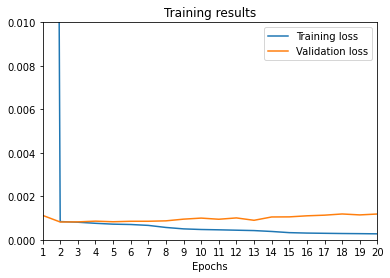

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(range(EPOCHS), range(1, EPOCHS+1))
plt.xlabel("Epochs")
plt.xlim([0, EPOCHS-1])
plt.ylim([0, 0.01])
plt.legend(['Training loss', 'Validation loss'])
plt.title("Training results")
plt.show()

In [ ]:
gen_test = batch_gen(4, x_test, y_test)
x_true, y_true = next(gen_test)
y_pred = model.predict(x_true)

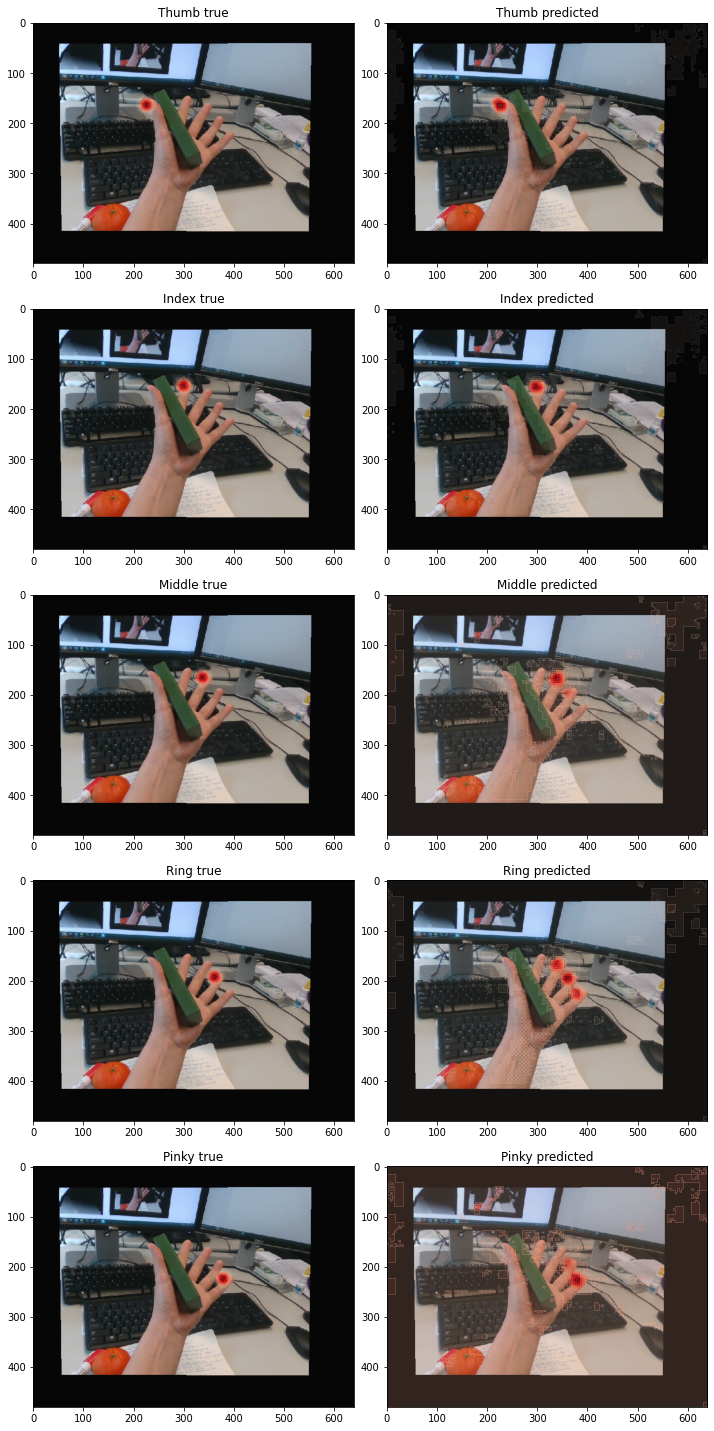

In [ ]:
x_t = x_true[0, ..., :3].astype(np.uint8)
y, x = np.mgrid[0:DIMS[0], 0:DIMS[1]]
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

labels = ["Thumb", "Index", "Middle", "Ring", "Pinky"]
for i in range(5):
  ax[i, 0].imshow(x_t)
  ax[i, 0].contourf(x, y, y_true[0, ..., i], 15, cmap=mycmap)
  ax[i, 0].set_title(f"{labels[i]} true")
  ax[i, 1].imshow(x_t)
  ax[i, 1].contourf(x, y, y_pred[0, ..., i], 15, cmap=mycmap)
  ax[i, 1].set_title(f"{labels[i]} predicted")

fig.tight_layout()
plt.show()